In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

class TwoTaskModel(nn.Module):
    def __init__(self):
        super(TwoTaskModel, self).__init__()
        self.shared_layers = nn.Sequential(
            nn.Linear(104, 128),
            nn.Linear(128, 64),
            nn.Linear(64, 32),
            nn.Linear(32, 16),
            nn.Dropout(0.1),
            nn.Linear(16, 8),
            nn.LeakyReLU(0.03),
            nn.Dropout(0.20),
            nn.Linear(8, 4),
            nn.LeakyReLU(0.01),
            nn.Dropout(0.25),
        )
        self.classification_head = nn.Linear(4, 2)
        self.regression_head = nn.Linear(4, 1)

    def forward(self, x):
        x = self.shared_layers(x)
        classification_output = self.classification_head(x)
        regression_output = self.regression_head(x)
        return classification_output, regression_output

In [14]:
# Load the datasets
train_data = torch.load('/lustre/home/sasha/GPM/train1.pt')
test_data = torch.load('/lustre/home/sasha/GPM/test1.pt')

# Assuming that train_data and test_data are tuples of features and labels
train_features, train_labels = train_data
test_features, test_labels = test_data

# Create the custom datasets
train_dataset = CustomDataset(train_features, train_labels)
test_dataset = CustomDataset(test_features, test_labels)
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128)

In [15]:
# Instantiate the model
model = TwoTaskModel()

# Define loss functions
classification_loss_fn = nn.CrossEntropyLoss()
regression_loss_fn = nn.MSELoss()

# Define an optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Define the number of epochs
num_epochs = 5

# Start the training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    for batch_idx, (features, labels) in enumerate(train_loader):
        # Split the labels for each task
        classification_labels = labels[:, :2].long()
        regression_labels = labels[:, 2].unsqueeze(1)  # Regression label needs to be a 2D tensor

        # Forward pass
        classification_output, regression_output = model(features)

        # Compute losses
        classification_loss = classification_loss_fn(classification_output, classification_labels.max(1)[1])
        regression_loss = regression_loss_fn(regression_output, regression_labels)

        # Combine losses
        loss = classification_loss + regression_loss

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch_idx % 100 == 0:  # Print loss every 100 batches
            print(f'Epoch {epoch}, Batch {batch_idx}, Loss: {loss.item()}')

Epoch 0, Batch 0, Loss: 3.876384735107422


Epoch 0, Batch 100, Loss: 4.729088306427002
Epoch 0, Batch 200, Loss: 5.2214035987854
Epoch 0, Batch 300, Loss: 27.863821029663086
Epoch 0, Batch 400, Loss: 1.930150032043457
Epoch 0, Batch 500, Loss: 17.89476776123047
Epoch 0, Batch 600, Loss: 30.774919509887695
Epoch 0, Batch 700, Loss: 3.5058224201202393
Epoch 0, Batch 800, Loss: 6.832050323486328
Epoch 0, Batch 900, Loss: 2.685271978378296
Epoch 0, Batch 1000, Loss: 8.779682159423828
Epoch 0, Batch 1100, Loss: 2.8665499687194824
Epoch 0, Batch 1200, Loss: 3.1087684631347656
Epoch 0, Batch 1300, Loss: 15.253146171569824
Epoch 0, Batch 1400, Loss: 4.762118816375732
Epoch 0, Batch 1500, Loss: 48.746360778808594
Epoch 0, Batch 1600, Loss: 21.00830841064453
Epoch 0, Batch 1700, Loss: 7.8075456619262695
Epoch 0, Batch 1800, Loss: 14.678210258483887
Epoch 0, Batch 1900, Loss: 2.015338897705078
Epoch 0, Batch 2000, Loss: 7.001933574676514
Epoch 0, Batch 2100, Loss: 3.446363687515259
Epoch 0, Batch 2200, Loss: 3.1191787719726562
Epoch 0, Ba

Overall F1 Score: 0.42794091417066377


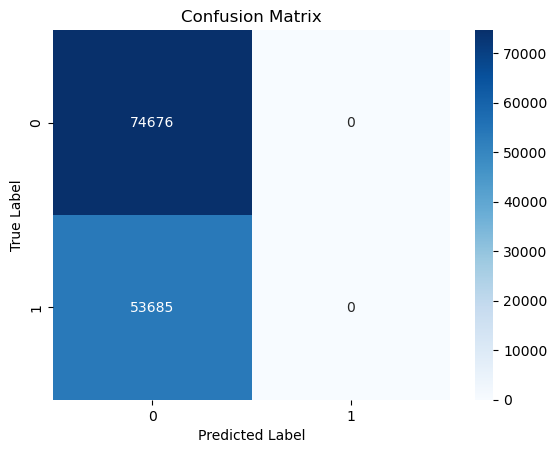

In [16]:
def calculate_classification_metrics(outputs, targets):
    _, predicted = torch.max(outputs, 1)
    targets = targets.max(dim=1)[1]  # Convert from one-hot to indices
    f1 = f1_score(targets.cpu().numpy(), predicted.cpu().numpy(), average='weighted')
    cm = confusion_matrix(targets.cpu().numpy(), predicted.cpu().numpy())
    return f1, cm

# Evaluate the model
model.eval()  # Set the model to evaluation mode
all_targets = []
all_predictions = []

with torch.no_grad():
    for features, labels in test_loader:
        classification_labels = labels[:, :2].long()
        classification_output, _ = model(features)
        
        f1, cm = calculate_classification_metrics(classification_output, classification_labels)
        all_targets.extend(classification_labels.cpu().numpy())
        _, predicted = torch.max(classification_output, 1)
        all_predictions.extend(predicted.cpu().numpy())

# Calculate overall F1 score and confusion matrix
overall_f1 = f1_score(np.argmax(all_targets, axis=1), all_predictions, average='weighted')
overall_cm = confusion_matrix(np.argmax(all_targets, axis=1), all_predictions)

print(f'Overall F1 Score: {overall_f1}')
sns.heatmap(overall_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()